# Sigmoid Multi-label Pipeline

Defaults: BCE loss, individual classifications per odor mixture

## Initialization

In [4]:
import pickle
import numpy as np
import importlib
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


In [7]:
N = 500 # number of odors (max: 500)
M = 2 # number of odors per mixture
THRESHOLD = 0.5 # threshold for binary classification

DSET_TYPE = "U" # one of [(B) binary, (U) noisy binary, (N) gaussian]

BATCH_SIZE = 64
NUM_EPOCHS = 5

MODEL_TO_LOAD = None


In [6]:
# Quickly load pickled data, write to index_file for dataset lookup
def create_index(pickle_file, index_file):
    offsets = []
    with open(pickle_file, 'rb') as file:
        while True:
            offset = file.tell()
            try:
                pickle.load(file)
                offsets.append(offset)
            except EOFError:
                break
    with open(index_file, 'wb') as file:
        pickle.dump(offsets, file)


In [22]:
class AddGaussianNoise(object):
    """Add Gaussian noise to a tensor."""
    def __init__(self, mean=0.1, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Adds Gaussian noise to a tensor.
        """
        noise = np.random.randn(1781) * self.std + self.mean
        return tensor + noise

In [177]:
import dataset
importlib.reload(dataset)

# datafile = f'data/{DSET_TYPE}_{N}_train.pkl'
datafile = 'data/B_500.pkl'
indexfile = f'indices/{DSET_TYPE}_{N}_train.idx'

create_index(datafile, indexfile)

lazy_chem_dataset = dataset.LazyChemDataset(
    pickle_file=datafile,
    index_file=indexfile,
    n_mixture=M,
    num_classes=N,
    # n_samples=5,
    transform=AddGaussianNoise()
)

train_size = int(0.8 * len(lazy_chem_dataset))
val_size = len(lazy_chem_dataset) - train_size
train_dataset, val_dataset = random_split(lazy_chem_dataset, [train_size, val_size])
train_dataset = lazy_chem_dataset


# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



## Model & Parameters

In [17]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, num_classes)  # Output logits, not probabilities

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [92]:
model = SimpleNet(input_size=1781, num_classes=N)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load model weights
if MODEL_TO_LOAD:
    model.load_state_dict(torch.load('N100_sigmoids.pt'))

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        # pos_weight should be a tensor of length equal to the number of classes
        # each weight corresponds to the positive class weight for each label
        self.pos_weight = pos_weight

    def forward(self, outputs, targets):
        # Initialize BCEWithLogitsLoss with pos_weight for handling class imbalance
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        return criterion(outputs, targets)

# Assume higher weight for the positive classes due to sparsity or imbalance
pos_weight = torch.ones(N) * 10  
loss_function = WeightedBCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # Ensure weights are on the same device as your model/data


## Training

In [19]:
# Accuracy measure function
def top_n_accuracy(preds, labels, n=2, correct_n=M):
    """
    Calculate the top-n accuracy for the given predictions and labels.
    """
    top_n_preds = preds.topk(n, dim=1)[1]  # Returns values and indices; [1] to get indices
    
    # Initialize the score
    score = 0.0

    for i in range(labels.size(0)):
        actual_labels = labels[i].bool()
        # select the label positions that are top n
        correct_preds = actual_labels[top_n_preds[i]].float()  
        score += correct_preds.sum().item() / correct_n

    return score

In [148]:
# Training loop
def train_model(model, loss_function, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        all_labels = []
        all_preds = []
        accuracy = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            outputs = model(data).squeeze(1)
            loss = loss_function(outputs, target)

            # Convert outputs to predicted labels
            predicted_probs = torch.sigmoid(outputs)  # Sigmoid to convert logits to probabilities
            predicted_labels = (predicted_probs > THRESHOLD).float()  # Threshold probabilities

            # Collect labels and predictions for F1 score calculation
            all_labels.append(target.cpu().numpy())
            all_preds.append(predicted_labels.cpu().numpy())
            accuracy += top_n_accuracy(predicted_probs, target, n=2, correct_n=2)

            # Backward and optimize
            optimizer.zero_grad()  # Clear gradients w.r.t. parameters
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters

            train_loss += loss.item() * data.size(0)

        # Calculate average loss
        train_loss /= len(train_loader.dataset)

        # Calculate F1 score
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        # train_f1_score = f1_score(all_labels, all_preds, average='macro')
        train_accuracy = accuracy / len(train_loader.dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        all_labels = []
        all_preds = []
        accuracy = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data).squeeze(1)
                loss = loss_function(outputs, target)

                # Convert outputs to predicted labels
                predicted_probs = torch.sigmoid(outputs)
                predicted_labels = (predicted_probs > THRESHOLD).float()

                # Collect labels and predictions for F1 score calculation
                all_labels.append(target.cpu().numpy())
                all_preds.append(predicted_labels.cpu().numpy())
                accuracy += top_n_accuracy(predicted_probs, target, n=M)

                val_loss += loss.item() * data.size(0)

        # Calculate average loss
        val_loss /= len(val_loader.dataset)

        # Calculate F1 score
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        # val_f1_score = f1_score(all_labels, all_preds, average='macro')
        val_accuracy = accuracy / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training statistics
        print(f'Epoch: {epoch+1}/{num_epochs} \t'
              f'Training Loss: {train_loss:.4f} \t Training Accuracy: {train_accuracy:.4f} \t'
              f'Validation Loss: {val_loss:.4f} \t Validation Accuracy: {val_accuracy:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies


In [178]:
t_losses, v_losses, t_accuracies, v_accuracies = [], [], [], []

In [179]:
# optimizer=optim.SGD(model.parameters(), lr=0.0001)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, loss_function, optimizer, 30)
t_losses += train_losses
v_losses += val_losses
t_accuracies += train_accuracies
v_accuracies += val_accuracies

Epoch: 1/30 	Training Loss: 0.6364 	 Training Accuracy: 0.2900 	Validation Loss: 0.6170 	 Validation Accuracy: 0.3640
Epoch: 2/30 	Training Loss: 0.6037 	 Training Accuracy: 0.2963 	Validation Loss: 0.5874 	 Validation Accuracy: 0.3666
Epoch: 3/30 	Training Loss: 0.5775 	 Training Accuracy: 0.3012 	Validation Loss: 0.5621 	 Validation Accuracy: 0.3684
Epoch: 4/30 	Training Loss: 0.5540 	 Training Accuracy: 0.3060 	Validation Loss: 0.5401 	 Validation Accuracy: 0.3704
Epoch: 5/30 	Training Loss: 0.5336 	 Training Accuracy: 0.3089 	Validation Loss: 0.5211 	 Validation Accuracy: 0.3719
Epoch: 6/30 	Training Loss: 0.5156 	 Training Accuracy: 0.3110 	Validation Loss: 0.5036 	 Validation Accuracy: 0.3724
Epoch: 7/30 	Training Loss: 0.4995 	 Training Accuracy: 0.3127 	Validation Loss: 0.4882 	 Validation Accuracy: 0.3730
Epoch: 8/30 	Training Loss: 0.4865 	 Training Accuracy: 0.3142 	Validation Loss: 0.4745 	 Validation Accuracy: 0.3738
Epoch: 9/30 	Training Loss: 0.4730 	 Training Accuracy: 

In [143]:
torch.save(model.state_dict(), 'U_500_pretrained.pt')

### Plotting for training

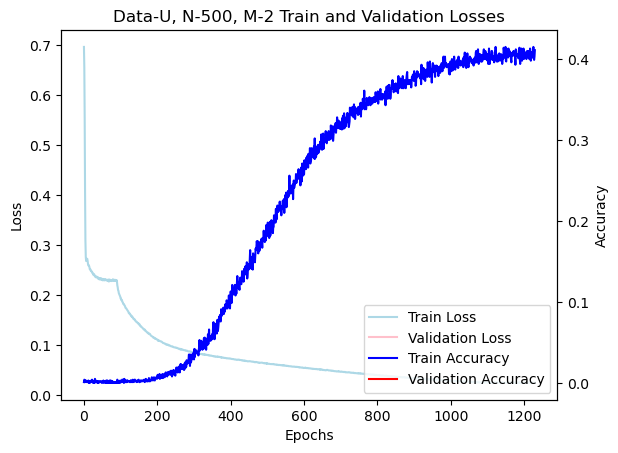

In [138]:
# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the train and validation losses
ax1.plot(t_losses, label='Train Loss', color='lightblue')
ax1.plot(v_losses, label='Validation Loss', color='pink')

# Set labels and title for the left axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title(f'Data-{DSET_TYPE}, N-{N}, M-{M} Train and Validation Losses')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the train and validation accuracies
ax2.plot(t_accuracies, label='Train Accuracy', color='blue')
ax2.plot(v_accuracies, label='Validation Accuracy', color='red')

# Set labels for the right axis
ax2.set_ylabel('Accuracy')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

# Show the plot
plt.show()


In [176]:
mix = train_dataset[5][0].unsqueeze(0).to(device) + train_dataset[3][0].unsqueeze(0).to(device)
outputs = model(mix).squeeze(1)
predicted_probs = torch.sigmoid(outputs)  # Sigmoid to convert logits to probabilities
label1 = train_dataset[5][1]
label2 = train_dataset[3][1]
label = torch.stack((label1, label2))
print(train_dataset[5])
print(predicted_probs.shape, label.shape)
top_n_accuracy(predicted_probs, labels, n=2, correct_n=2)


(tensor([ 0.2245, -0.0190,  0.2083,  ...,  0.0130,  0.0537, -0.1258]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

IndexError: index 3 is out of bounds for dimension 0 with size 2

## Testing

In [ ]:
# Prepare data for final evaluation of model
create_index('testing.pkl', 'testing.idx')
test_set = dataset.LazyChemDataset('100testing.pkl', '100testing.idx', M, N)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [152]:
# Testing loop
def test(top_n):
    running_correct = 0
    total = 0
    all_labels = []
    all_preds = []

    # Loop through test_loader
    for mix, label in test_loader:
        if not mix.shape:  # Skip batches that somehow have no data
            continue
        outputs = model(mix).squeeze(1)
        predicted_probs = torch.sigmoid(outputs)  # Sigmoid to convert logits to probabilities
        predicted_labels = (predicted_probs > 0.7).float()  # Thresholding probabilities at 0.3
        # running_correct += (predicted_labels == label).float().sum().item()
        running_correct += top_n_accuracy(predicted_probs, label, n=top_n, correct_n=2)
        # print(predicted_probs.shape, label.shape)
        total += 1

        # Collect labels and predictions for F1 score calculation
        all_labels.append(label.cpu().numpy())
        all_preds.append(predicted_labels.cpu().numpy())

        # # Debugging output
        # print("True labels: ", label[0])
        # print("Predicted labels: ", predicted_labels[0])
        # print("Perfect match: ", torch.equal(label[0], predicted_labels[0]))
        print(predicted_probs, predicted_labels)
        if total >= 1:
            break


    # Calculate overall accuracy and F1 score
    accuracy = running_correct / (total * 64)
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')  # 'macro' averaging considers label imbalance
    f1_none = f1_score(all_labels, all_preds, average=None)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, f1, f1_none


NameError: name 'test_loader' is not defined

In [ ]:
# Plot F1 Scores
_, _, f1_none = test(top_n=2)

# Create a bar plot of the F1 scores
plt.figure(figsize=(10, 6))
plt.bar(range(N), f1_none, color='skyblue')
plt.xlabel('Odor Index')
plt.ylabel('F1 Score')
plt.xticks(ticks=np.arange(0, N, 10), 
           labels=[i for i in np.arange(0, N, 10)],
           rotation=45)
plt.title('Weighted BCE Loss, F1 Scores per Label')
plt.ylim(0, 1)  # F1 score ranges from 0 to 1
plt.show()

In [ ]:
# Plot Top-n accuracy
accuracies = []
for i in [2, 5, 10, 15]:
    print(f"Top-{i} Accuracy:")
    accuracy, _, _ = test(i)
    accuracies.append(accuracy)

# Create a line plot of the top-n accuracies
plt.figure(figsize=(10, 6))
plt.plot([2, 5, 10, 15], accuracies, marker='o', color='skyblue')
plt.xlabel('Top-N')
plt.ylabel('Accuracy')
plt.title('Weighted BCE Loss, Top-N Accuracy')
plt.grid(True)
plt.show()